## 9.1 Stock Data
1. Scope:
    - have data on stock prices (open, close, high, low)
    - have 1000 client apps accessing this data
2. Assumptions:
    - data is going to be read-only. don't want client apps to change the prices
    - they might be requesting the data only every couple of hours since i assume stock prices don't change that much and they are asking for end-of-day stock price info
3. Major Components:
    - database to contain all of this info
        - probably going to use a SQL-based DBMS like MySQL for the job. since it's mostly going to be read-only queries involved, don't need the DBMS to have complicated queries or actions
    - going to have some sort of API to handle all client requests and to query database
        - going to use node.js to create it since you can make clusters of the instance if traffic is heavy but it is simple enough for what we're doing
4. Key Issues:
    - if we just run one instance of the node.js api then it can be a big bottleneck if all of the clients make the requests within a small time period
    - if we only have one database with all the info, then it could also be a source of a bottleneck if there are multiple queries going on
5. Redesign:
    - we can scale the api by using node.js clusters which will have clusters that can divide the traffic and handle all of the requests simultaneously. decent solution if we make use of a multi-core system that can do this
    - we could have clones of the database that the clusters could access. it will also divide up the queries

### Book Solutions:
* want to focus on how to distribute info to clients
* need to think about these various aspects of the solution:
    - Client Ease of Use: should be easy to implement and be useful for clients
    - Ease for Ourselves: needs to be easy for us to implement and should be mindful of the cost of implementation and maintenance
    - Flexibility for Future Demands: solution should not be too constraind and should be flexible enough to handle any changes in demand
    - Scalability and Efficiency: solution should be efficient enough for us without sacrificing ease of use
***
Proposal #1:
* could keep data in text files of some kind so that clients could download it
* easily maintained since info could be backed up and viewed
* disadvantages:
    - would have to require parsing this text file to respond to any queries
    - client would have to parse these files somehow and if the structure of the file changes, then the parsing mechanism could break
***
Proposal #2:
* could use a standard SQL database and let clients query from that
* benefits:
    - very easy to query for any sort of data
    - rollbacks, backing up data, and security are a standard part so we don't have to do it ourselves
    - really easy for the client to integrate this into their apps b/c a SQL database is so widely used
* disadvantages:
    - a SQL database is kind of overkill for what we have to do since there aren't really many complex queries or other features that we need for a simple news feed
    - difficult to read the data so need some sort of way to convert it to something readable so that's an implementation cost
    - need to be careful about how much access we allow clients to have.
    - clients can perform expensive and inefficient queries that we have to pay for
***
Proposal #3:
* using XML to distribute information
    - great b/c it has a fixed format and size
* advantages:
    - easy to distribute and can be easily read by both humans and machines
        - XML is a standard data model to share and distribute data b/c of this
    - most languages have libraries that can parse XML really easily so clients don't have to do much to implement this
    - can add additional data to the XML file without breaking the clients' parsing mechanism
    - can use existing tools for backing up data in XML files and we don't need to implement our own
* disadvantages:
    - no way for clients to only query for the parts that they want. they get ALL of the info even if they don't need it so it is inefficient
    - any queries would require parsing of the entire XML file
***
* could provide a web service for client data access
    - it's a bit of work on our end to implement but it adds some more security and it can be easier for the client to integrate it to their app
    - clients will have to adhere their queries to how we want though so this is both a pro and a con. clients will have to adhere to our guidelines but clients will be very limited if they have unique queries

## 9.2 Social Network

1. Scope:
    - what features should this social network have? 
        - profiles, connections, messages, etc
    - who is the target audience?
        - linkedin and facebook cater to different user bases.
        - one is for professionals looking for jobs or posting up job offers
        - the other is a way for families, friends, acquaintances to connect
        - identifying the user audience is important to determine what features it should have
2. Assumptions:
    - going to assume a generic facebook-like social network
    - going to have a user profile, friends list, etc
    - able to message between user and their friends either 1-1 or group chat
    - going to have some sort of a timeline for user's to create posts and share them
3. Major components:
    - user profile
    - friends list
    - messaging system
    - timeline
    - data structure to use: a graph
        - a network itself is like a big graph so it's a no-brainer for the social network to be one as well
        - the social network itself is going to be a large graph with each of its nodes acting as a feature
            - so one node for profiles
            - one node for messaging system
            - one node for timelines etc
        - the user profiles themselves are graphs with each node being assign a different function
            - one node for mutuals
            - one node for user's information
            - another node for posts
            - and one for any messages
4. Key issues:
    - might have redundant information in each graph and will be pretty tedious to update them
    - so we have to update the messages in the user profile graph and in the messaging system node in the social network graph
5. Redesign:
    - should just keep that information in one place to make it more efficient to update
    - so all messages should be kept in the messaging system node and the user's messaging node has a reference to all their conversations
***
* for the shortest path between two users based on their mutuals:
    1. should be using a breadth-first search to find the shortest path
    2. essentially you run a double bfs until you land on a mutual user between the two
        - so you run bfs from user1 --> user2
        - and you simultaneously rn one from user2 --> user1
        - if the algorithm lands on the same mutual or on one that the other already looked through, then you have found the shortest path
    3. the way the data structure is set up for the social network as a big graph will help tremendously in this b/c you will have a list of friends/mutuals to work with for the double-bfs method
* a possible optimization would be to first look through all the connections of user1 and check if they are also user 2's connections
    - if there is 1 match, then that mutual is the shortest path between the two users and the double-bfs method is not necessary
    - it would probably be faster to do this than jumping straight into double-bfs b/c if both of the users have huge amounts of connections, like 5k+, then that is a lot of mutuals to go through

### Book Solutions:

* Step 1: Simplify the Problem - Forget About the Millions of Users
    - can construct a graph by treating each person as a node and letting edge between nodes indicate that they are friends
    - finding a path between two people could be accomplished with bfs with one of the people as the first node
    - dfs would not work well b/c it would keep going deeper and deeper down one person's connections even if the two people are separated by 1 mutual. 
    - alternatively, can do a birdirectional breadth-first search where we start at both of the users until the searches collide at a point. 
        - this is the fastest method
        - but it does require having both a source node and a destination node which is not always the case
        
* Step 2: Handle the Millions of Users
    - for a service the size of Facebook, data must be kept on multiple machines
    - so each user must have a list of their friends as user IDs and we must traverse each machine for a specific id
    - so traversal is:
        1. for each friend ID: let machine_index = getMachineIDForUser(personID);
        2. go to machine #machine_index
        3. on that machine: let friend = getPersonWithID(person_id);
***
* Optimization: reduce machine jumps
    - jumping from one machine to another is expensive so just look up all the friends we need to on one machine then move onto the next instead of looking for each one at a time
* Optimization: Smart division of people and machines:
    - should divide people by their backgrounds so that people with similar backgrounds are on the same machine rather than having random people in different machines
    - so should divide by country, city, state, etc
* Question: Breadth-first search usually requires 'marking' a node as visited. How do you do that in this case?
    - since multiple searches can be going on at the same time, marking nodes isn't going to work
    - should instead have some sort of a hash table to keep that info and look it up if we want to check if it's been visited

## 9.3 Web Crawler

1. Scope:
    - what are the infinite loops in regards to?
    - is there a possibility for infinite loops when crawling within a domain's contents or are we talking about infinite loops when crawling through the entire web?
        - the answer to this could change the way the algorithm is designed
2. Assumptions:
    - assume infinite looping in regards to pages within a site so mypage/about vs mypage/faq, etc
    - assume site is a multi-page application rather than a single-page one
3. Major Components:
    - could have a hash table that takes in the URL of the page currently being crawled
    - if the crawler enters a site that it's already seen before, it will abort the operation and move onto other pages or sites
    - within that hash table, each site will also have info on the contents of the site
    - should have another hash table with some info on common html elements like head or body tags to make a comparison in case the URL check fails
4. Key issues:
    - for URLs, there could be sites that have similar URLs but pretty much the same content and that could be accidentally crawled infinitely
    - it also doesn't take into account the same domains/subdomains for a page
5. Redesign:
    - the hash table should also add in info on domains/subdomains that have similar extensions, etc
    - especially for sites that use QUERIES at the end of the URLs which would have different URLs but pretty much the same content

### Book Solutions:
* how does an infinite loop occur?
    - the web can be viewed as a graph of links and therefore if there is a cycle in this graph, then an infinite loop can occur while crawling
* to prevent infinite loops:
    - would need to detect any cycles
    - can be done by creating a hash table where hash[v] = true for any page, v, that has already been visited
* thus when we crawl a web using bfs, we visit each page, put the links into a queue, and after fulling visiting it, we put it into a hash table
* but what does it mean for a page to be already visited?
    - we could say that a page is visited if the URL is already in the hash table.
        - this is flawed however b/c sometimes URLs can be distinct but the contents of the page can still be the same.
        - this is especially the case with queries added toe the URL
    - we could say that a page is visited if we have different content on it.
        - but if the content is randomly generated but the page is the same, then we have entered an infinite loop by constantly crawling it
* thus a solution would be to compare the similarities between the pages we've already seen and the current page we're crawling. if they are very similar, we deprioritize crawling its children
* for example:
    1. have a db with a list of items we need to crawl. on each iteration, we pick the highest priority page to crawl then
    2. open up the page and create a signature of it based on specific subsections of the page and its URL
    3. query the db to see if the signature has been crawled recently
    4. if something comes up, reinsert this page back into the db with a low priority since we've already seen it
    5. if not, crawl the page and insert links into the db

## 9.4 Duplicate URLs

1. Scope:
    - what should we do with the duplicate URLs? should we just notify someone that there is a duplicate URL or should it be removed?
    - how are these URLs gathered and stored in the first place? is there a list of these URLs or do we have to crawl for them?
    - is there a distinction between domains and subdomains?
        - do maps.google.com and google.com count as duplicates?
2. Assumptions:
    - assume that the whole URL has to be unique
        - so google.com/results, google.com, and maps.google.com are three unique results
    - also assume that the URLs are stored in a list of some sort, like an array
3. Algorithm:
    1. want to have iterate through the entire list of URLs and add them to a hash table
    2. while iterating, check to see if the URL is already in the hash table. if it is, then we can notify that it is a duplicate and move on. 
        - this will essentially take O(n) space where n = # of URLs. in this case, n = 10 billion URLs
        - it should only take 1 pass through this list of URLs to notify and find any duplicates b/c as you pass through the list, you only keep track of unique URLs in the hash table and any duplicates will immediately be found
        - it should only take 1 machine to do
4. Key issues:
    - if we wanted to scale this further to more than 10 billion URLs, we might not have enough space to fit all the URLs onto one machine
5. Redesign:
    - we could split up the list of URLs into multiple parts and do the same algorithm on multiple machines
    - then once we are done, we can compare all the URLs in each hash table to see if there are duplicates between the hash tables

### Book Solutions:
* how much space does 10 billion URLs take up?
    - each URL is about 100 chars on avg and each char is 4 bytes
    - so 10 bil URLs ~= 4 terabytes
* pretend that a machine can actually hold this much data in memory
    - we can then just create a hash table and map each URL we iterate through and identify the duplicates that way
    - or we can sort through the list for duplicates
* but realistically, we would have to split up this data across multiple machines

***
Solution #1: Disk Storage
* if all data was stored on one machine, this could be done in 2 passes:
    1. first pass splits up URLs into 4000 chunks of 1GB each
        - this can be done by storing each URL, u, in a file named <x>.txt where x = hash(u) % 4000. 
        - thus the URLs with the same hash value will be in the same file
    2. in the second pass, we can just load each one into memory and create a hash table of the URLs and look for duplicates

***
Solution #2: Multiple Machines
* we can do the same procedure as solution 1 but with multiple machines instead of files
* just send the URL to some machine and create hash tables and look for duplicates
* advantages:
    - the task can be done in parallel on multiple machines
    - so looking through all 4k chunk will take less time
* disadvantage:
    - we now rely on 4000 different machines to act perfectly
    - and it is much more complex working with this many machines than just disk storage

## 9.5 Cache

1. Scope:
    - does processSearch(query) get results from a subset of the 100 machines available or is it from an entirely different cluster of machines?
    - is processSearch(query) expensive in time or in space?
    - how recent should the search results be? should it only be the most recent 1k, 100k, 1 million, etc results?
2. Assumptions:
    - assume a different set of machines handles the search than the current 100 machines
    - assume processSearch() is a time-expensive thing
    - assume data from machines are sent back to the web server
    - assume most recent 100k results
3. Major components:
    - web server that assigns a query to a random machine
    - 100 machines that are randomly selected for the results
    - the separate cluster of machines that handle the actual search
    - the client that sends the query to the web server
    - a hash table containing the most recent results
        - key = the query which is a string
        - value = the result sent back from processSearch()
        - on the web server, it will receive the query from the client and check it against this hash table
        - if it is present in the table, then return the result. else, call on one of the machines to call processSearch()
        - and if we have reached the threshold of 100k results in the table, the remove the oldest ~10k or so results in the table to make room for more
4. Key Issues:
    - will require some space for the hash table if there are lots of results to be cached
    - removal of the oldest 10k results in a hash table might be difficult b/c results are not ordered in any way
    - and it might be costly to remove that many results
5. Redesign:
    - use of a linked list with each node being a hash table
    - linked list will have a head pointer and a tail pointer and the hash table has a capacity of ~10k results
    - so once we reach the 10k results, the linked list will add another node at the head that contains another hash table
    - and the node at the tail will be removed
    - searching for the result will not be expensive b/c there will be at most 10 nodes for the most recent 100k results
    - and removing the oldest 10k results is as simple as updating the tail pointer to reference the node prior to the last one

### Book Solutions:
* Assumptions (just some of the many valid assumptions we can make):
    - other than calling out to processSearch as necessary, all query processing happens on the initial machine that was called
    - number of queries we wish to cache is large (millions)
    - calling between machines is relatively quick
    - the result for a given query is an ordered list of URLs, each of which has an associated 50 character title and 200 character summary
    - most popular queries are extremely popular, such that they would always appear in the cache
* System Requirements:
    - efficient lookups given a key
    - expiration of old data to be replaced with new data
    - must handle updating/clearing the cache when results for a query change
    
***
Step 1: Design a Cache for a Single System
* start by designing it with just one machine
* linked list would be easy to purge old data by moving fresh items to the front and just remove last element in list when linked list exceeds a certain size
* hash table allows for efficient lookups of data but wouldn't allow for an easy way to get rid of old data
* can combine both a linked list and a hash table to get the best of both worlds:
* linked list with freshest node move to the front every time it is accessed and the stalest at the end
* hash table maps from a query to the respective node in the linked list which will return the cached result and be able to move it to the front of the list

***
Step 2: Expand to Many Machines:
* to what extent should the cache be shared across machines?
* Option 1: Each machine has its own cache:
    - so if the same query is sent to machine 1 twice, the first time processSearch is called and its result is added to the cache, and the second time, we return the result from the cache
    - but if the same query was sent to machine 1 and machine 2, then each machine will treat it as a new query and call processSearch
    - it's relatively quick but there will be duplicate queries that would be treated as fresh ones
* Option 2: Each machine has a copy of the cache
    - when new items are added to the cache, they will also be sent to every machine as well to update their own cache
    - so any duplicate queries will be returned exclusively from the cache
    - the major drawback is that you would have to update every machine every time you have a new item
* Option 3: Each machine stores a segment of the cache
    - divide up the cache and each machine holds a distinct part of it
    - so if a query is sent to machine 1, it could ask machine 2 to look for the result in their cache, etc
    - can assign queries using a hash, where hash = hash(query) % N
    - then machine i only needs to apply this formula to know that machine j should store the results for this query
    - we can then use this hash to find out which machine has the answer to the query. if the machine has it, return the result from its cache. if not, then call processSearch

***
Step 3: Updating results when contents change:
* some queries may be so popular that they would be permanently cached.
* thus we need some way to allow for the cached results to be refreshed when things change
* so when would be a good time to change or refresh the cache?
    1. when the content at a URL changes (or the page at that URL is removed)
    2. the ordering of results change in response to the rank of a page changing
    3. new pages appear related to a particular query
* for sitatuions 1 and 2, we could have separate hash tables that relate it to a specific URL and thus can be updated when the URL changes
    - this will require a lot of data since this hash table will be separated from the rest
* or alternatively, we could crawl through the cache stored on each machine and purge queries tied to the updated URLs
* situation 3 is pretty difficult to handle compared to the first 2.
    - to handle it, we can have an automatic time-out on the cache.
    - so each query has a set time limit for being in the cache, and afterwards will be removed automatically, ensuring that the cache is periodically refreshed

***
Step 4: Further Enhancements:
* having bettersupport for popular queries. so instead of forwarding the request to another machine, the current machine can just forward the request once and cache the results itself
* the automatic time-out mechanism can have differing times based on the topic.
    - things like news articles and stuff could have a shorter time in the cache while more mundane things can have longer times in the cache

## 9.6 Sales Rank

1. Scope:
    - how are these products stored? is there just one general table called 'Products' are are they already stored by categories such as Sports, Home, Kitche, etc
    - does each product have a list of categories that describe what it is meant for? like if a product was part of Kitchen, Home, Utensil or something
    - is there a master list of all available categories in the eCommerce site?
    - are the categories stagnant or do they add new categories?
2. Assumptions:
    - assume that all products are stored in one table called 'Products' with a list of categories describing what the product is menat for
    - assume that there is some sort of master list with all the categories of their products available
    - assume that the master list is stagnant and no new categories are added into it
3. Major Components:
    - list of all products on the site
    - list of all categories of products
    - the system would work like this:
        - it would iterate through every product in the Products table
        - and it would then create an array for each category that the products are attached to, i.e. create a Sports array and a Home array
        - then it would add the product to this array
        - once all products are accounted for, each of these arrays will then be sorted by # of products sold and to determine the rankings
        - this would also be done for the Overall category as well
        - and the system would only be doing this every hour or so. could be more frequent if the eCommerce site usually has a high amount of traffic. so it could be done every 15 minutes or so
4. Key issues:
    - if there is a huge amount of products available, then iterating through each one then sorting them by categories will be an expensive task time-wise
    - not to mention it would also require a lot of space too to store all the products in arrays for each category
5. Redesign:
    - would be able to cache some of the results of the previous rankings and make adjustments if necessary.
    - this would be good if some products are not as frequently sold as others so their rankings are quite stagnant whereas the more frequently sold items would need to be constantly sorted

### Book Solutions:

Step 1: Scope the Problem:
* assume we only design components related to this question and not entire eCommerce system. so we only touch designs of frontend and purchase components since it affects sales rankings
* what exactly does sales rank mean? is it lifetime sales? sales in the last month? by which metric are we raking these things?
    - will just assume total sales in the past week
* assume each product can be in multiple categories and there are no subcategories

*** 
Step 2: Make Reasonable Assumptions:
* assume stats don't need to be 100% up-to-date. they can be an hour old for most popular items or a day old for less popular ones.
* precision is more important for the most popular items but we can be off for the less popular ones
* assume data updated hourly for most popular items but time range doesn't need to be as strict
    - so doesn't need data for last 168 hours. the last 150 hours is ok
* assume categorizations based strictly on origin of transaction, i.e. sellers' name, and not the price or date

***
Step 3: Draw the Major Components:

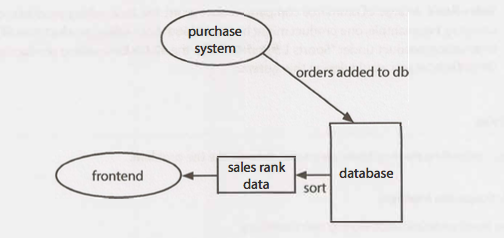

* store every order as soon as it comes into db
* pull sales data from db by category on an hourly basis
* we then compute the total sales, sort it, then store it in some sort of sales rank data cache
* frontend will just pull sales rankings from this cache

***
Step 4: Identify the Key Issues:
* Analytics are Expensive:
    - each product will have the number of sales in the past week for each product so you basically run a query for all sales for all time
    - we just need to track the total sales
    - so instead of listing every purchase, we just store total sales from the last week using a table that we update
    - just use a table with product id and the total sales with each day of the week as a column. then these will reset once a full week is over
    - we also need a separate tabl for product IDs and their categories and we can join this table with the total sales to calculate the rankings
* Database Writes are Very Frequent:
    - there is going to be a large amount of writes to the database b/c everytime a purchase is made, we update the total sales in the data
    - instead, we can place each purchase into a cache and we would periodically process these sales together in a bundle
        - so instead of throwing each piece of garbage into the dump outside every time, we can instead have a trash bag that collects all these pieces and we can throw it into the dump outside every once in a while
    - then once it's updated, we can re-calculate the sales rank data
    - this could be biased for some products so to alleviate this, we wait until all the data in the cache is accounted for before recalculating the ranks
* Joins are Expensive:
    - we could instead have a column for the Category with the total sales and week information
    - we wouldn't need any joins if we did this
* Database Queries Might Still Be Expensive
    - if queries and writes get really expensive, we could just use log files rather than a database
    - this would allow us to use something like Google's MapReduce
    - so we write a purchase to a text file with product ID and a time stamp
    - each category has its own directoy and each purchase gets written to all categories associated with the product
    - then we can start merging the files together by product ID and time ranges so that they're all grouped by a given day
    - to get the best-sellers, we can sort each directory
    - how do we get the overall ranking?
        1. treat the general category as just another directory and write every purchase to that directory. but it would have a lot of files though
        2. since the products are already sorted by sales volume for each category, just do an N-way merge to get the overall ranking

## 9.7 Personal Financial Manager

1. Scope:
    - what types of features exactly should be available?
        - when they say 'Make recommendations' do they mean make recommendations on spending habits? on stocks? what exactly is it?
    - how do we connect to the bank accounts of these users and how often should their data be requested? what kind of data do we need from them?
    - what types of habits are we looking for in terms of spending and how exactly do we categorize it?
2. Assumptions:
    - assume that it will track purchases that are provided by bank statements and make recommendations on how to reduce spending and budget for other things
    - should probably categorize by essential and non-essential purchases. should probably give the user the ability to categorize their purchases as well since some users prioritize some purchases over others, e.g. streamers prioritize faster internet speeds whereas the avg person will just get an average plan
3. Major Components:
    - some sort of API that will help connect us to people's bank account information in regards to purchases. Chase bank has its own API for that sort of thing so might have to use multiple APIs to get access to all the popular banks
    - will have a database of some kind to store information on purchases for up to a year or some other predefined amount of time and each purchase will be categorized by essential or non-essential or some other categories as well
    - will need some sort of analytics implemented to show spending in general to the user
    - the API should be updated every day or every couple of days to show trends in spending habits so far
4. Key issues:
    - not a lot of the data that we fetch needs to be put into a database if we can already request it from bank APIs so having it would just be a waste of space
    - not to mention users will have variable purchasing habits so it is hard to tell whether to request the data frequently or infrequently from these APIs
5. Redesign:
    - the user should get to decide how often their purchases should be fetched. some users might like to look at this info on a monthly basis while others might want to look at it daily. this will help reduce the amount of calls to these APIs
    - purchases should not be kept in a database at all and instead their spending habits should be saved. any time we want to look at purchases, we ask the API. and any time users want to look at prior spending habits, we already have it saved in our database.

### Book Solutions:

Step 1: Scope the Problem:
* can create an account and add bank accounts to it. can have multiple bank accounts that can be added at any time
* pulls financial history from bank accounts
* history includes purchase history, salary info or other sources of income, and current balances/investments
* each payment transaction has a category, e.g. food, travel, clothing, etc
* there is some data source that ensures the purchase is properly categorized or the user has the ability to override it in case it is wrong
* users will use the system to get recommendations on their spending. so things like % income shouldn't be used on clothing, etc and these percentages can be customized
* just a website but might have mobile app later
* email notifcations like daily summary or due to other conditions like hitting a budget cap
* no user-specific rules for assigning categories to transactions

***
Step 2: Make Reasonable Assumptions:
* adding or removing bank accounts is relatively unusual
* system is write-heavy. typical user may make several new transactions a day while others would only access it weekly
* once transaction is assigned a category, only the user has the power to override it. the system should not be able to change the categories
* need to pull data from the banks
* alerts for exceeding budgets should be sent after 24 hours

***
Step 3: Draw the Major Components
* naive system would pull bank data on each login, categorize the data, then analyze user's budget
* instead, we can do this:

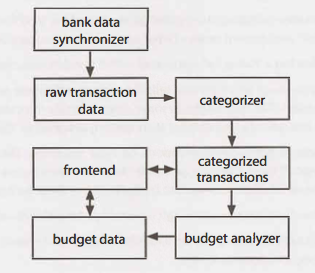

* bank data is pulled periodically (hourly/daily) depending on how active the user is
* once data arrives, it is stored in some list of unprocessed transactions and would then be pushed to a categorizer
* categorizer would then push the categorized transactions to another datastore
* budget analyzer pulls in categorized transactions and updates user's budget per category and stores user's budget
* frontend pulls this data from both transactions datastore and budget datastore
* user could also interact with frontend to change budget or categorization of transactions

***
Step 4: Identify Key Issues:
* this is a really data-heavy system so we want many of these processes to be asynchronous so that the user can still do other things while waiting
* should have some sort of queue that makes sure high priority things are being done but also that every task is done as well
    - it should also be able to re-try failed tasks
* email system should have some sort of a queue for to notify the user whenever they have exceeded their budget
    - so if a transaction leads to this, the task will be queued up
* should also have a system that removes or deprioritizes users that are not as active.
    - should keep track of user's account activity for this
* biggest bottleneck is the amount of data that needs to be pulled and analyzed so we should fetch the bank data asynchronously and analyze them across many servers
* Categorizer and Budget Analyzer:
    - transactions are not dependent of each other so as soon as we get it, we can process it
    - with so many transactions though, we might just have to store them into a text file and group them up by the seller's name
    - then after categorizing it, it regroups all transactions by the user and then they are inserted into a datastore for the user
    - the budget analyzer will then merge all the info for each category and then update the budget
    - so the log files handle most of the tasks and the processed data is then stored in a database.
        - this minimizes reading and writing from the database
* User Changing Categories:
    - might override particular transactions to a separate category
    - so all we have to do is update the datastore for the categorized transactions and recompute the budget by decrementing the old category and incrementing the new one

## 9.8 Pastebin

1. Scope:
    - should we allow text formatting of some kind like justifying, italicizing, highlighting, etc or should it just be a standard copy/paste thing
    - does the url contain the domain name and how long should it be?
    - how long should the URL last for? is there a time limit or is it permanent? if it has a time-limit, can users choose how long the URL should be accessible for?
    - what type of info should the page have? should it just be text or will it have some data like who the user is on it
    - should these pastebins have some sort of accessibility option like public, private, password-protected, etc
    - are users allowed to edit the contents of a pastebin after the URL has been generated?
2. Assumptions:
    - should probably have simple things like new lines and indentation but not highlighting or stuff like in word processors
    - URL should contain domain name and should have some identifying string at the end of the URL
    - all URLs should stay online unless the user chooses not to and the contents of it should be editable.
    - also assuming that all pastebins are publically accessible without any of the private/protected options
3. Major Components:
    - some database that contains the generated link and pastebin contents/info
    - a web server that generates a new link and handles the routing to them
    - URLs should be generated like so:
        - pastebin.com/[string of random numbers and letters]
        - so pastebin.com/a1f93k2fdskj9
    - then once the URL is generated, it will be checked against the database if that already exists. if it does, generate a new, random string of chars
4. Key issues:
    - if there are a lot of new URLs being generated, the database will be overloaded really quickly with tons of URLs and generating/checking the URLs and adding it to the database can be both time and space intensive
    - some URLs will have higher traffic than others. for example, a pastebin link that is posted in a forum vs. in a group chat will have many more users checking it out. so must find a way to balance it
5. Redesign:
    - we could partition the database once it reaches a certain size. can check for duplicate URL in one partition, then move onto the next one. although the key issue with this is that you might have a duplicate in one partition and not another and a duplicate can occur. so you have to check every partition to make sure.
    - having some sort of a load balancer and multiple instances of the server could alleviate some of the traffic.

### Book Solutions:

Step 1: Scope the Problem:
* no user accounts or editing documents
* tracks analytics of how many times a page is accessed
* old documents get deleted if they aren't accessed for a certain amount of time
* users should not be able to guess document URLs easily and there shouldn't be true authentication on document accessibility
* has a frontend and an API
* analytics for each URL can be accessed through a stats link on each page.

***
Step 2: Make Reasonable Assumptions:
* system gets heavy traffic and has millions of documents
* traffic not equally distributed across documents. some are more heavily accessed than others

***
Step 3: Draw the Major Components:
* need to keep track of URLs, the files associated with them, and the analytics
* we can store the documents on a file since we won't need searching capabilities

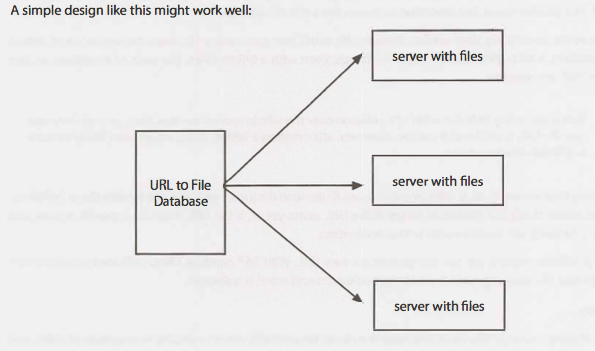

* simple database that looks up location of each file
* if we have a request for a URL, we look up location of the URL within the datastore and then access the file
* will also have a database that tracks analytics
    - each row will add some sort of data like ip address, location, timestamp for each visit and we can then pull and analyze this information if anyone wants to see it

***
Step 4: Identify the Key Issues:
* some documents will be accessed more frequently than others so reading from a file system is going to be slow
    - instead we can store the most recently accessed documents into a cache
    - if the document is heavily accessed, we just return from the cache rather than having to look for it in the file system
* could also shard the database as well and map the URL to a certain shard of it using a hash function to locate it quickly
* Generating URLs:
    - want to generate URLs that are hard for a user to guess since we don't want them to access it without knowing the link
    - we could just generate a 10-character sequence of letters and numbers which would generate 36$^{10}$ possible strings to use but if we have billions of URLs and the possibility of a collision is pretty low even if we have billions of URLs saved up
    - to handle collisions, we can check whether the URL already exists. if it does, just regenerate a new URL.
        - since collisions will be quite rare with this many possible string combinations, regenerating a new one won't be an issue
* Analytics:
    - two options for analytics:
        1. store raw data from each visit
        2. store just the data we know we'll use (number of visists)
    - would probably want raw data since new analytic features could be implemented in the future and we would be glad we had that data
    - the amount of space needed could be huge if we stored data on all visits.
        - instead we could have something called a storage_probability that acts as a way to measure how often we need to store a visit
        - so if the site is heavily accessed, we just need to store a visit every 10 visits or so
        - then afterwards, we can multiply the number of visits in the store by the storage_probability to get an estimated amount of visits for a particular site
    - since stats are not normally displayed on a page and a user goes out of their way to click a link to see it, there the servers shouldn't face much load from getting the stats
        - for heavily accessed URLs, we could cache this data so that we wouldn't have to reaccess it for further optimization